# Assignment-2

Student: Ufuk Cem Birbiri

#tools.py

In [64]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd

from scipy.optimize import minimize
from scipy.stats import norm, uniform, binom
from scipy.stats import gaussian_kde
from scipy.stats import multivariate_normal

def laplace_solution(params, other_params, data, lik, priors):
  
    def evaluate_log_post(params, other_params, data, lik, priors):
        model_list = { 'gaussian' : norm, 'uniform': uniform, 'binomial' : binom}
    
        model_lik = model_list[lik]
    
        #Computing log-priors
        log_prior = 0
        for i,mod in enumerate(priors):
            log_prior += model_list[mod[0]].logpdf(params[i], *mod[1])

            
        #Computing log-likelihood
        if lik == 'gaussian':
            # Dirty trick for guaranteeing positive variance
            params[-1] = np.abs(params[-1])
                
        if len(other_params)>0:
            log_lik = np.sum([model_list[lik].logpdf(point, *(params,other_params)) for point in data])
        else:
            log_lik = np.sum([model_list[lik].logpdf(point, *params) for point in data])
        return - (log_lik + log_prior)
    
    minimum =  minimize(evaluate_log_post, params,  
                        args = (other_params, data, lik, priors), method = 'BFGS')
    print(minimum)
    return [minimum.x, minimum.hess_inv]


def laplace_solution_regression(expression, data, lik, priors):
    model_list = { 'gaussian' : norm, 'uniform': uniform, 'binomial' : binom}
    
    def evaluate_log_post(params, var_names, data, lik, priors):
        model_list = { 'gaussian' : norm, 'uniform': uniform, 'binomial' : binom}
        model_lik = model_list[lik]
    
        #Computing log-priors
        log_prior = 0
        for i,mod in enumerate(priors):
            log_prior += model_list[mod[0]].logpdf(params[i], *mod[1])

        #Evaluating expression
        target, predictors = var_names[0], var_names[1]
        
        mu = np.ones(len(data[predictors[0]])) * params[0]
        
        for i in range(len(predictors)):
            mu += params[i+1] * data[predictors[i]].values
            
        sigma = np.abs(params[-1])
        
        t = data[target].values
        N = len(t)
               
        log_lik = np.sum([model_list['gaussian'].logpdf(t[i], mu[i], sigma) for i in range(N)])
        return -(log_lik + log_prior)
    
    collapsed_expression = expression.replace(" ", "")
    target, independent = collapsed_expression.split('~') 
    independent = independent.split('+')
    var_names = [target, independent]
    
    params = []
    for i in range(len(priors)):
        params.append(model_list[priors[i][0]].rvs(*priors[i][1]))
    
    minimum =  minimize(evaluate_log_post, params, args = (var_names, data, lik, priors), method = 'BFGS')
    print(minimum)
    return [minimum.x, minimum.hess_inv]

def post_sample_Laplace(solution, N_sample):
    posterior_samples = multivariate_normal.rvs(solution[0], solution[1], size = N_sample)
    return posterior_samples

def posterior_stats(solution, names, plot = False):
    posterior_samples = post_sample_Laplace(solution, 1000)
    post_quantiles = np.quantile(posterior_samples, q = [0.075, 0.925], axis = 0)
    # sd
    post_sd = np.std(posterior_samples, axis = 0)
    # mean
    post_mean = np.mean(posterior_samples, axis = 0)
    summary_stats = [post_mean, post_sd, post_quantiles[0,:],post_quantiles[1,:]]
    summary_stats = pd.DataFrame(summary_stats).transpose()
    summary_stats.columns = ['mean', 'SD', '7.5%', '92.5%']
    summary_stats.index = names
    #summary_stats.rename(index=list(names), inplace=True)
    print(summary_stats)
    if plot:
        boxes = []
        for i in range(len(post_mean)):
            boxes.append(posterior_samples[:,i])
        plt.boxplot(boxes,vert=0)
        plt.yticks(range(len(post_mean)+1)[1:], names)
        plt.axvline(x=0, color = 'black', alpha = 0.1)
        plt.show()

def posterior_plot_univariate_regression(solution, x_range, data, center = 0, names = ['x','y'], N_samples = 500):
    post_samples = post_sample_Laplace(solution, N_samples)
    degree = post_samples.shape[1] - 1

    post_mean = np.mean(post_samples, axis = 0)

    mean_prediction = np.zeros(len(x_range))
    for i in range(degree):
        mean_prediction += post_mean[i] * x_range**i 

    plt.plot(x_range + center, mean_prediction, lw = 2, color = 'black')
    plt.title('regression result')
    plt.ylabel(names[1])
    plt.xlabel(names[0])

    list_model_samples = []
    #sampling from the posterior to get a predictive interval
    for n in range(N_samples):
        mod_sample = np.zeros(len(x_range))
        for i in range(degree):
            mod_sample += post_samples[n,i] * x_range**i
        list_model_samples.append(mod_sample)

    prediction_noise = []
    for i,mod_sample in enumerate(list_model_samples):
        prediction_noise.append(norm.rvs( mod_sample, post_samples[i,-1]))  

    # Plotting the uncertainty
    for i in range(N_samples): 
        plt.scatter(x_range + center, prediction_noise[i], alpha = 0.05, color = 'grey')
        plt.scatter(x_range + center, list_model_samples[i], alpha = 0.05, color = 'green')

    plt.scatter( data[names[0]] + center, data[names[1]])
 


#Exercise 1




 Consider the model:

$$p(x|\theta)\propto \frac{1}{\sqrt{2\pi}}\exp(-\frac{(x_1-\theta)^2+(x_2-\theta)^2}{2}).$$

Find a Laplace approximation for this model, as seen for the Binomal model, and plot the resulting Gaussian approximation. Can you related this model to the posterior of the mean of a Gaussian as seen in class (Lesson 3)?

**Answer 1.1**

Let's find the Laplace approximation for this model:
$$p(x|\theta)\propto \frac{1}{\sqrt{2\pi}}\exp(-\frac{(x_1-\theta)^2+(x_2-\theta)^2}{2}).$$

1- We take logarithm:

$$\log(p) = \frac{1}{\sqrt{2\pi}} (-\frac{(x_1-\theta)^2+(x_2-\theta)^2}{2})$$

We omit the $\frac{1}{\sqrt{2\pi}}$ part since it is constant.

2- Find the maximum of the log-distribution. we derive with respect to $\theta$ and solve:

$$\frac{d\log(p)}{d\theta} = \frac{+2(x_1 - \theta)}{2} + \frac{+2(x_2 - \theta)}{2} = 0 \Longrightarrow x_1- \theta + x_2 - \theta= 0$$.

$$ \theta = \frac{x_1 + x_2}{2}$$

3- Find the second derivative of the log-distribution with respect to $\theta$:
$$\frac{d^2\log(p)}{d\theta^2} = -2$$

The approximation will be a Gaussian with mean $\mu = \frac{x_1 + x_2}{2}$ and variance $\sigma^2 = 1/2$.

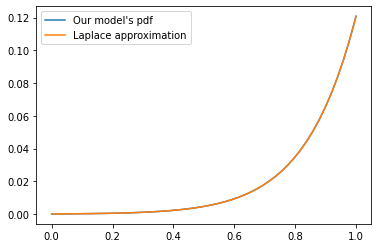

In [65]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt


## we define the parameters here:

x_1 = 3
x_2 = 5

theta = np.linspace(0,1)

p = np.exp( (-1/2) * ((x_1 - theta)**2 + (x_2 - theta)**2) )


plt.plot(theta,p/np.sum(p), label = 'Our model\'s pdf')

p_max = (x_1 + x_2) / 2

Hessian = -2

var = -1/Hessian

Laplace_approx = norm(p_max, np.sqrt(var))

plt.plot(theta, Laplace_approx.pdf(theta)/np.sum(Laplace_approx.pdf(theta)), label = 'Laplace approximation')
plt.legend()

Let's define $x_1$ and $x_2$ with different values:


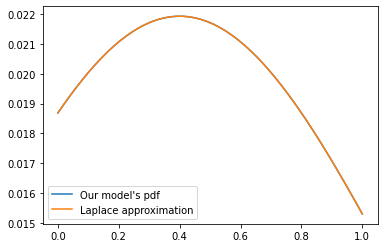

In [66]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt


## we define the parameters here:

x_1 = 0.3
x_2 = 0.5

theta = np.linspace(0,1)

p = np.exp( (-1/2) * ((x_1 - theta)**2 + (x_2 - theta)**2) )


plt.plot(theta,p/np.sum(p), label = 'Our model\'s pdf')

p_max = (x_1 + x_2) / 2

Hessian = -2

var = -1/Hessian

Laplace_approx = norm(p_max, np.sqrt(var))

plt.plot(theta, Laplace_approx.pdf(theta)/np.sum(Laplace_approx.pdf(theta)), label = 'Laplace approximation')
plt.legend()

Changing the $x_1$ and $x_2$ values also didn't give us any Gaussian distribution.

**Can you related this model to the posterior of the mean of a Gaussian as seen in class (Lesson 3)?**

No I cannot relate it because the function p is an exponential function. Also the Laplace approximation of p is not a Gaussian model, it is also exponential. So, the Laplace approximation technique is not a good idea for exponential functions (at least in this case). 

#Exercise 2

**Exercise 2**. Write down a model to evaluate the claim: *Animal diversity is related to latitude, but only after controlling for plant diversity*. You just need to write down the model definition.

What I understand is that animal diversity depends on two variables namely latitude and plant diversity. We cannot omit plant diversity since we should control the plant diversity before measuring the animal diversity. This problem looks like a regression problem where animal diversity is (linearly) related to other factors. So let's define the model:

We say that Animal diversity is a Gaussian distribution:

$Animal$ $diversity\sim N(\mu_i,\sigma^2)$
where $\mu_i$ is the mean of this distribution. Let's say $L$ is latitude and $P$ is the plant diversity. Then our model becomes:

$\mu_i = \alpha + \beta_L L_i + \beta_P P_i$

where $\alpha$, $\beta_L$, and $\beta_P$ are regression coefficients.

#Exercise 3

The attached data is about observations of urban foxes in human habitat. The data has 5 columns:

- *group*: Number of social group the fox belongs to
- *avgfood*: The avg amount of food available in the territory
- *groupsize*: The number of foxes in the social group
- *area*: Size of the territory
- *weight*: Body weight of the fox

Fit a regression for *weight* as a linear function of *area*, and a regression for *weight* as a linear function of *groupsize*. What can you say about these relationships? Run a multivariate model with both variables, what can you conclude about this analysis?

###1. Fit a regression for *weight* as a linear function of *area*


We are interested in the relationship:

$$\mbox{weight} = a + b * \mbox{area},$$

We want to find posterior distributions for the regression coefficients $a$ and $b$. 

Assume that the *weight* is dependent on the variable *area* through a linear relationship. In this case, the *weight* of a fox $i$ is a sample from a Gaussian model:

$$\mbox{weight}_i\sim N(\mu_i,\sigma^2),$$

where $\mu_i = a + b * \mbox{area}_i$. A reminder that while we allow the mean $\mu_i$ to vary depending on the area, the coefficients $a$ and $b$, as well as the noise $\sigma$ are the same across each subject.  
Now we should define our priors for all the parameters we want to analyze:

$$ p(a) = N(75, 100),$$

$$ p(b) = N(0, 10),$$

$$ p(\sigma) = U(0, 50).$$

Let's code:

In [67]:
import pandas as pd
#Load the data:
data_original  = pd.read_csv('/content/data_assignments2.csv', sep=',')
data = data_original.copy()
data.head(3)

,group,avgfood,groupsize,area,weight
0,1,0.37,2,1.09,5.02
1,1,0.37,2,1.09,2.84
2,2,0.53,2,2.05,5.33


We center the data before plotting weight vs area to avoid scale effects:

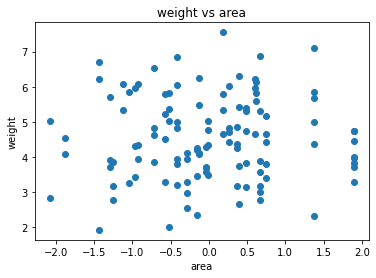

In [68]:
mean_area = np.mean(data.area)
#Center it:
data.area = data.area - mean_area

plt.scatter(data.area, data.weight)
plt.ylabel('weight')
plt.xlabel('area')
plt.title("weight vs area")
plt.show()

Linear Model:

$$\mbox{weight}_i = a + b * \mbox{area}_i,$$

$$\mbox{weight}_i\sim N(\mu_i,\sigma^2),$$

$$\mu_i = a + b * \mbox{area}_i$$

/usr/local/lib/python3.7/dist-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/local/lib/python3.7/dist-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/local/lib/python3.7/dist-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


      fun: 2878.2607051380746
 hess_inv: array([[ 1.33808502, -0.0059968 , -0.08608005],
       [-0.0059968 ,  1.00010616,  0.00195333],
       [-0.08608005,  0.00195333,  0.12229164]])
      jac: array([ 14.97018433,  -0.22418213, -91.85699463])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 74
      nit: 3
     njev: 16
   status: 2
  success: False
        x: array([312.88422164,  -4.34124096,  48.91996622])
post_mean =  [312.832146    -4.37497866  48.94209105]
post_sd =  [1.18528718 0.98438712 0.35104273]



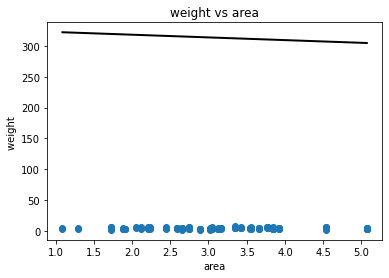

In [69]:
# linear model
expr = 'weight ~   area'

# Initializing the likelihood
likelihood = 'gaussian'
# Defining the prior with hyperparameters 

prior_a_mean = 75
prior_a_sigma = 100
prior_a = ['gaussian', [prior_a_mean, prior_a_sigma]]

prior_b_mean = 0
prior_b_sigma = 10
prior_b = ['gaussian', [prior_b_mean, prior_b_sigma]]

sigma_inf = 0
sigma_sup = 50
prior_sigma_unif = [sigma_inf, sigma_sup]
prior_sigma = ['uniform', prior_sigma_unif]

priors = [prior_a, prior_b, prior_sigma]

solution_regression = laplace_solution_regression(expr, data, likelihood, priors)

# Computing posterior samples

posterior_samples = multivariate_normal.rvs(solution_regression[0], solution_regression[1], size = 1000)
#print(posterior_samples)

# sd
post_sd = np.std(posterior_samples, axis = 0)
# mean
post_mean = np.mean(posterior_samples, axis = 0)
print("post_mean = ",post_mean)
print("post_sd = ",post_sd)
print()

#Plot:
x_range = np.linspace(min(data.area), max(data.area))
mean_prediction = post_mean[0] + post_mean[1] * x_range

plt.plot(x_range + mean_area, mean_prediction, lw = 2, color = 'black')
plt.scatter(data.area + mean_area, data.weight)
plt.title('weight vs area')
plt.ylabel('weight ')
plt.xlabel('area')
plt.show()



In [70]:
# Computing summary stats
# 95% confidence interval
post_quantiles = np.quantile(posterior_samples, q = [0.025, 0.975], axis = 0)
# sd
post_sd = np.std(posterior_samples, axis = 0)
# mean
post_mean = np.mean(posterior_samples, axis = 0)

summary_stats = [post_mean, post_sd, post_quantiles[0,:],post_quantiles[1,:]]

summary_stats = pd.DataFrame(summary_stats).transpose()
summary_stats.columns = ['mean', 'SD', '2.5%', '97.5%']
summary_stats.rename(index={0:'a',1:'b', 2:'sigma'}, inplace=True)
print(summary_stats)

             mean        SD        2.5%       97.5%
a      312.832146  1.185287  310.527756  315.230858
b       -4.374979  0.984387   -6.330639   -2.569936
sigma   48.942091  0.351043   48.286516   49.601992


Now let's explore the variability of the prediction by using the posterior samples for the coefficients that we computed before:

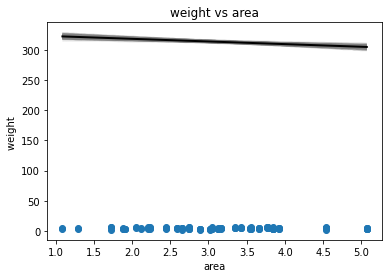

In [71]:
#sampling from the posterior

for i in range(1000):
    prediction = posterior_samples[i,0] + posterior_samples[i,1] * x_range
    plt.plot(x_range + mean_area, prediction, lw = 0.05, color = 'grey')

plt.scatter(data.area + mean_area, data.weight)
plt.plot(x_range + mean_area, mean_prediction, lw = 2, color = 'black')
plt.title('weight vs area')
plt.ylabel('weight ')
plt.xlabel('area')
plt.show()




[]

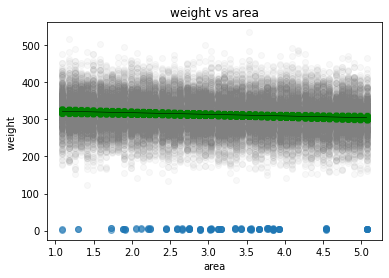

In [72]:
prediction_range = []
#sampling from the posterior to get a predictive interval
for x_ in (x_range):
    prediction_range.append(posterior_samples[:500,0] + posterior_samples[:500,1] * x_)  

prediction_range_noise = []

#sampling from the posterior to get a predictive interval
for x_ in (x_range):
    prediction_range_noise.append(norm.rvs(posterior_samples[:500,0] + posterior_samples[:500,1] * x_,  
                                           posterior_samples[:500,2]))  
    
# Plotting the uncertainty
for i,x_ in enumerate(x_range): 
    plt.scatter(np.repeat(x_,500) + mean_area, prediction_range_noise[i], alpha = 0.05, color = 'grey')
for i,x_ in enumerate(x_range): 
    plt.scatter(np.repeat(x_,500) + mean_area, prediction_range[i], alpha = 0.05, color = 'green')


plt.scatter(data.area + mean_area, data.weight, alpha = 0.5)
plt.plot(x_range + mean_area, mean_prediction, lw = 0.5, color = 'black')
plt.title('weight vs area')
plt.ylabel('weight ')
plt.xlabel('area')
plt.plot()

We can conclude that the impact of area on the weight variable is small since the slope(b) is nearly flat, and the mean estimate of b is 0.027197 (near to zero).

###2. Fit a regression for *weight* as a linear function of *groupsize*

We don't know the effect of groupsize on weightso we are gonna  do the same pipeline for groupsize as we did in area.


We are interested in the relationship:

$$\mbox{weight} = a + b * \mbox{groupsize},$$

We want to find posterior distributions for the regression coefficients $a$ and $b$. 

Assume that the *weight* is dependent on the variable *groupsize* through a linear relationship. In this case, the *weight* of a fox $i$ is a sample from a Gaussian model:

$$\mbox{weight}_i\sim N(\mu_i,\sigma^2),$$

where $\mu_i = a + b * \mbox{groupsize}_i$. A reminder that while we allow the mean $\mu_i$ to vary depending on the area, the coefficients $a$ and $b$, as well as the noise $\sigma$ are the same across each subject.  
Now we should define our priors for all the parameters we want to analyze:

$$ p(a) = N(75, 100),$$

$$ p(b) = N(0, 10),$$

$$ p(\sigma) = U(0, 50).$$

Let's code:

We center the data before plotting weight vs area to avoid scale effects:

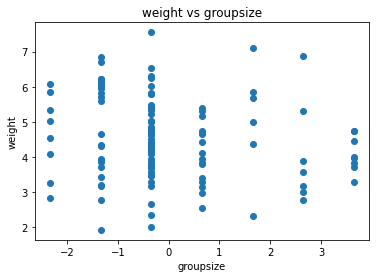

In [73]:
#Copy the original dataset:
data2 = data_original.copy()

##Center it:
mean_groupsize = np.mean(data.groupsize)

data2.groupsize = data2.groupsize - mean_groupsize

plt.scatter(data2.groupsize, data2.weight)
plt.ylabel('weight')
plt.xlabel('groupsize')
plt.title("weight vs groupsize")
plt.show()

Linear Model:

$$\mbox{weight}_i = a + b * \mbox{groupsize}_i,$$

$$\mbox{weight}_i\sim N(\mu_i,\sigma^2),$$

$$\mu_i = a + b * \mbox{groupsize}_i$$

      fun: 195.07205215333806
 hess_inv: array([[ 1.09150433e-02, -2.45196423e-04, -1.46318382e-04],
       [-2.45196423e-04,  4.71740178e-03, -9.50008991e-05],
       [-1.46318382e-04, -9.50008991e-05,  5.82670563e-03]])
      jac: array([3.81469727e-06, 0.00000000e+00, 0.00000000e+00])
  message: 'Optimization terminated successfully.'
     nfev: 132
      nit: 28
     njev: 33
   status: 0
  success: True
        x: array([ 4.52973747, -0.123893  ,  1.16352962])
post_mean =  [ 4.52472226 -0.12597563  1.16124752]
post_sd =  [0.10553102 0.07147924 0.07939031]



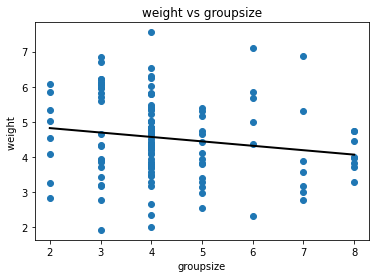

In [74]:
# linear model
expr = 'weight ~   groupsize'

# Initializing the likelihood
likelihood = 'gaussian'
# Defining the prior with hyperparameters 

prior_a_mean = 75
prior_a_sigma = 100
prior_a = ['gaussian', [prior_a_mean, prior_a_sigma]]

prior_b_mean = 0
prior_b_sigma = 10
prior_b = ['gaussian', [prior_b_mean, prior_b_sigma]]

sigma_inf = 0
sigma_sup = 50
prior_sigma_unif = [sigma_inf, sigma_sup]
prior_sigma = ['uniform', prior_sigma_unif]

priors = [prior_a, prior_b, prior_sigma]

solution_regression = laplace_solution_regression(expr, data2, likelihood, priors)

# Computing posterior samples

posterior_samples = multivariate_normal.rvs(solution_regression[0], solution_regression[1], size = 1000)
#print(posterior_samples)

# sd
post_sd = np.std(posterior_samples, axis = 0)
# mean
post_mean = np.mean(posterior_samples, axis = 0)
print("post_mean = ",post_mean)
print("post_sd = ",post_sd)
print()

#Plot:
x_range = np.linspace(min(data2.groupsize), max(data2.groupsize))
mean_prediction = post_mean[0] + post_mean[1] * x_range

plt.plot(x_range + mean_groupsize, mean_prediction, lw = 2, color = 'black')
plt.scatter(data2.groupsize + mean_groupsize, data2.weight)
plt.title('weight vs groupsize')
plt.ylabel('weight ')
plt.xlabel('groupsize')
plt.show()



In [75]:
# Computing summary stats
# 95% confidence interval
post_quantiles = np.quantile(posterior_samples, q = [0.025, 0.975], axis = 0)
# sd
post_sd = np.std(posterior_samples, axis = 0)
# mean
post_mean = np.mean(posterior_samples, axis = 0)

summary_stats = [post_mean, post_sd, post_quantiles[0,:],post_quantiles[1,:]]

summary_stats = pd.DataFrame(summary_stats).transpose()
summary_stats.columns = ['mean', 'SD', '2.5%', '97.5%']
summary_stats.rename(index={0:'a',1:'b', 2:'sigma'}, inplace=True)
print(summary_stats)

           mean        SD      2.5%     97.5%
a      4.524722  0.105531  4.320058  4.732892
b     -0.125976  0.071479 -0.265461  0.015314
sigma  1.161248  0.079390  0.998266  1.303260


Now let's explore the variability of the prediction by using the posterior samples for the coefficients that we computed before:

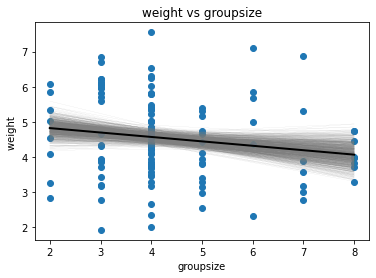

In [76]:
#sampling from the posterior

for i in range(1000):
    prediction = posterior_samples[i,0] + posterior_samples[i,1] * x_range
    plt.plot(x_range + mean_groupsize, prediction, lw = 0.05, color = 'grey')

plt.scatter(data2.groupsize + mean_groupsize, data.weight)
plt.plot(x_range + mean_groupsize, mean_prediction, lw = 2, color = 'black')
plt.title('weight vs groupsize')
plt.ylabel('weight ')
plt.xlabel('groupsize')
plt.show()




[]

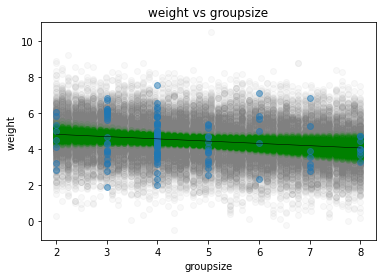

In [77]:
prediction_range = []
#sampling from the posterior to get a predictive interval
for x_ in (x_range):
    prediction_range.append(posterior_samples[:500,0] + posterior_samples[:500,1] * x_)  

prediction_range_noise = []

#sampling from the posterior to get a predictive interval
for x_ in (x_range):
    prediction_range_noise.append(norm.rvs(posterior_samples[:500,0] + posterior_samples[:500,1] * x_,  
                                           posterior_samples[:500,2]))  
    
# Plotting the uncertainty
for i,x_ in enumerate(x_range): 
    plt.scatter(np.repeat(x_,500) + mean_groupsize, prediction_range_noise[i], alpha = 0.05, color = 'grey')
for i,x_ in enumerate(x_range): 
    plt.scatter(np.repeat(x_,500) + mean_groupsize, prediction_range[i], alpha = 0.05, color = 'green')


plt.scatter(data2.groupsize + mean_groupsize, data2.weight, alpha = 0.5)
plt.plot(x_range + mean_groupsize, mean_prediction, lw = 0.5, color = 'black')
plt.title('weight vs groupsize')
plt.ylabel('weight ')
plt.xlabel('groupsize')
plt.plot()

The mean value of the slope(b) in groupsize is -0.123171. It is negative because the slope is negative. We can conclude that the impact of groupsize on the weight is larger than area(b=0.027197) since the absolute value of the slope in groupsize greater than the value of slope in area i.e. (0.123171 > 0.027197). The effect of groupsize is weakly negative with weight. 

###3. Fit a regression for *weight* as a linear function of both *area* and *groupsize*

$$\mbox{weight}_i = a + b * \mbox{age}_i + c * \mbox{groupsize}_i,$$

$$\mbox{weight}_i\sim N(\mu_i,\sigma^2),$$

$$\mu_i = a + b * \mbox{age}_i * + c * \mbox{groupsize}_i$$

Run a multivariate model with both variables, what can you conclude about this analysis?

In [78]:
data3 = data_original.copy()

In [79]:

expr = expr = 'weight ~   area + groupsize'

# Initializing the likelihood
likelihood = 'gaussian'

# Defining the prior with hyperparameters 
prior_a_mean = 0.5
prior_a_sigma = 10
prior_a = ['gaussian', [prior_a_mean, prior_a_sigma]]

prior_b_mean = 0
prior_b_sigma = 1
prior_b = ['gaussian', [prior_b_mean, prior_b_sigma]]

prior_c_mean = 0
prior_c_sigma = 1
prior_c = ['gaussian', [prior_c_mean, prior_c_sigma]]

sigma_inf = 0
sigma_sup = 10
prior_sigma_unif = [sigma_inf, sigma_sup]
prior_sigma = ['uniform', prior_sigma_unif]

priors = [prior_a, prior_b, prior_c, prior_sigma]

solution_regression_fat = laplace_solution_regression(expr, data3, likelihood, priors)
#posterior_stats(solution_regression_fat,['a_fat','b_fat','c_fat', 'sigma_fat'])
#posterior_plot_univariate_regression(solution_regression_fat, np.arange(0,75,0.5), data3, names=['area','groupsize'])

      fun: 185.29414256387707
 hess_inv: array([[ 0.16789886, -0.07082731,  0.01602019, -0.00292686],
       [-0.07082731,  0.03195263, -0.00801732,  0.0011278 ],
       [ 0.01602019, -0.00801732,  0.00282016, -0.00020172],
       [-0.00292686,  0.0011278 , -0.00020172,  0.00565056]])
      jac: array([-5.72204590e-06, -9.53674316e-06, -1.14440918e-05,  1.90734863e-06])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 150
      nit: 22
     njev: 30
   status: 2
  success: False
        x: array([ 4.46827132,  0.58788997, -0.41478024,  1.11856806])


In [80]:
posterior_stats(solution_regression_fat,['a','b','c', 'sigma'])


           mean        SD      7.5%     92.5%
a      4.496167  0.411972  3.885264  5.096729
b      0.576375  0.179983  0.317023  0.832080
c     -0.411020  0.053096 -0.491391 -0.335792
sigma  1.115896  0.072737  1.010334  1.214525


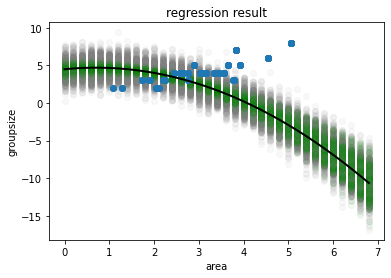

In [81]:
posterior_plot_univariate_regression(solution_regression_fat, np.arange(0,7,0.2), data3,  names = ['area','groupsize'])
#The resulted plot shows our prediction and groupsize-area correlation.


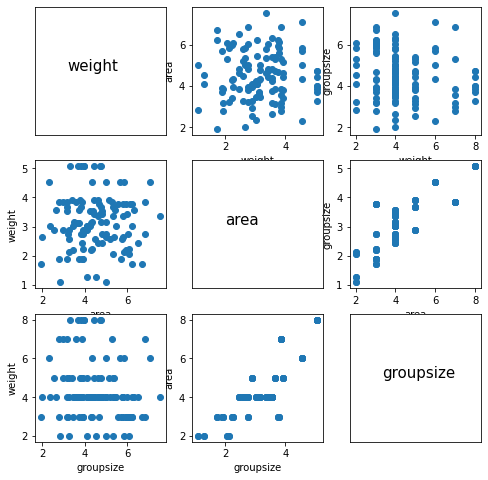

In [82]:
fields = ['weight',  'area', 'groupsize']

plt.figure(figsize=(8,8))

for i, field in enumerate(fields):
    
    for j in range(len(fields)):
    
        plt.subplot(len(fields), len(fields), len(fields)*i + j + 1)
        
        if i==j:
            plt.text(0.25,0.5, field, fontsize=15)
            plt.xticks([])
            plt.yticks([])
        else:
            plt.scatter(data3[fields[j]], data3[field])
            plt.ylabel(str(fields[j]))
            plt.xlabel(str(fields[i]))

When we look at the plot of area and group size, we can see that they are positively correlated. If there is an increase in area, there is an increase also in groupsize, however there is a worse prediction.


#Exercise 4

**Exercise 4.** Consider the diabetes dataset

In [95]:
from sklearn import datasets 
import numpy as np
import matplotlib.pyplot as plt

dataset = datasets.load_diabetes(return_X_y=False)
print(dataset.DESCR)

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

In [96]:
# Define the feature matrix
data = dataset.data
# Define the target
target = dataset.target

Investigate the relationship between age (data[:,0]) and Average blood pressure (data[:,3]) with a linear and quadratic model. 

- Which model do you think is better? 
- Predict a 95% confidence interval for the average blood pressure on an individual with mean age (0). 



In [97]:
data.shape, target.shape, type(data)

((442, 10), (442,), numpy.ndarray)

In [98]:
import pandas as pd 
df = pd.DataFrame(data, columns = ['age','sex','bmi','bp','s1','s2','s3','s4','s5','s6'])
df.head(3)


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930


We copy the data frame to use it in quadratic model and in the last question:


In [99]:
df_quadratic = df.copy()
df_3 = df.copy()
df_linear = df.copy()

Let's plot the age vs bp:

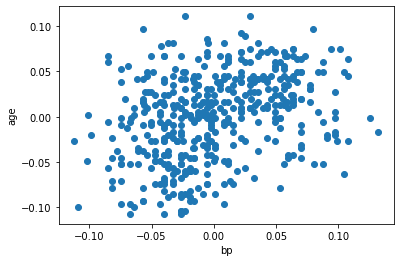

In [100]:
plt.scatter(df.bp , df.age)
plt.xlabel('bp')
plt.ylabel('age')
plt.show()

The data already has been mean centered and scaled so we don't center it again.

###1. Linear Model:

$$\mbox{age}_i = a + b * \mbox{bp}_i,$$

$$\mbox{age}_i\sim N(\mu_i,\sigma^2),$$

/usr/local/lib/python3.7/dist-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


      fun: -731.144626437007
 hess_inv: array([[ 4.42684096e-06, -4.66087081e-06, -1.16497310e-07],
       [-4.66087081e-06,  1.40057146e-05,  4.55250318e-06],
       [-1.16497310e-07,  4.55250318e-06,  2.21715301e-06]])
      jac: array([-2.28881836e-05,  0.00000000e+00,  7.62939453e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 274
      nit: 47
     njev: 68
   status: 2
  success: False
        x: array([7.33073788e-08, 3.35419972e-01, 4.48095172e-02])


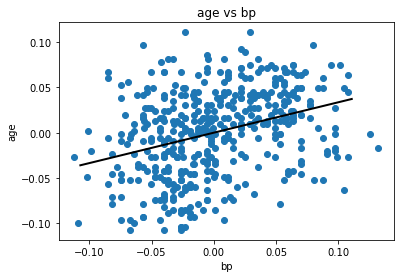

In [101]:
# linear model
expr = 'age ~   bp'

# Initializing the likelihood
likelihood = 'gaussian'
# Defining the prior with hyperparameters 

prior_a_mean = 178
prior_a_sigma = 100
prior_a = ['gaussian', [prior_a_mean, prior_a_sigma]]

prior_b_mean = 0
prior_b_sigma = 10
prior_b = ['gaussian', [prior_b_mean, prior_b_sigma]]

sigma_inf = 0
sigma_sup = 50
prior_sigma_unif = [sigma_inf, sigma_sup]
prior_sigma = ['uniform', prior_sigma_unif]

priors = [prior_a, prior_b, prior_sigma]

solution_regression_lin = laplace_solution_regression(expr, df_linear, likelihood, priors)

# Computing posterior samples

posterior_samples_lin = multivariate_normal.rvs(solution_regression_lin[0], solution_regression_lin[1], size = 1000)


# sd
post_sd_lin = np.std(posterior_samples_lin, axis = 0)
# mean
post_mean_lin = np.mean(posterior_samples_lin, axis = 0)


# Plot the average results
x_range = np.linspace(min(df_linear.age), max(df_linear.age))
mean_prediction_lin = post_mean_lin[0] + post_mean_lin[1] * x_range

plt.plot(x_range , mean_prediction_lin, lw = 2, color = 'black')
plt.scatter(df_linear.bp ,df_linear.age)
plt.title('age vs bp')
plt.ylabel('age')
plt.xlabel('bp')
plt.show()



In [102]:
# LINEAR - Computing summary stats

# 95% confidence interval
post_quantiles_lin = np.quantile(posterior_samples_lin, q = [0.025, 0.975], axis = 0)
# sd
post_sd_lin = np.std(posterior_samples_lin, axis = 0)
# mean
post_mean_lin = np.mean(posterior_samples_lin, axis = 0)

summary_stats_lin = [post_mean_lin, post_sd_lin, post_quantiles_lin[0,:],post_quantiles_lin[1,:]]

summary_stats_lin = pd.DataFrame(summary_stats_lin).transpose()
summary_stats_lin.columns = ['mean', 'SD', '2.5%', '97.5%']
summary_stats_lin.rename(index={0:'a',1:'b', 2:'sigma'}, inplace=True)
print(summary_stats_lin)

           mean        SD      2.5%     97.5%
a     -0.000003  0.002210 -0.004595  0.004324
b      0.335379  0.003843  0.328002  0.343088
sigma  0.044799  0.001474  0.042038  0.047823


###2. Quadratic Model:

$$\mbox{age}_i = a + b * \mbox{bp}_i + c * \mbox{bp}^2_i$$

$$\mbox{age}_i\sim N(\mu_i,\sigma_ı^2),$$

We add another coefficient for the quadratic term namely 'c'

      fun: -729.13690464984
 hess_inv: array([[ 5.55235163e-06, -6.22285549e-06, -8.62951146e-07,
         2.31843997e-07],
       [-6.22285549e-06,  2.12527719e-03,  9.02372184e-07,
        -8.49987500e-07],
       [-8.62951146e-07,  9.02372184e-07,  1.24070609e-04,
        -3.59578172e-06],
       [ 2.31843997e-07, -8.49987500e-07, -3.59578172e-06,
         2.36293048e-06]])
      jac: array([7.62939453e-06, 7.62939453e-06, 7.62939453e-06, 0.00000000e+00])
  message: 'Optimization terminated successfully.'
     nfev: 305
      nit: 45
     njev: 61
   status: 0
  success: True
        x: array([ 0.00281839,  0.35258351, -1.24569653,  0.04468585])


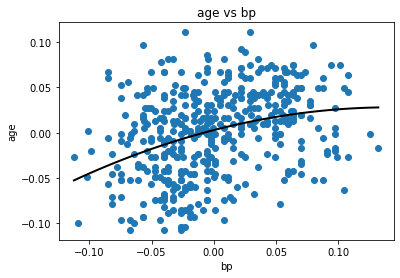

In [103]:
df_quadratic["bp2"]= df_quadratic.bp * df_quadratic.bp

# linear model
expr = 'age ~ bp + bp2'

# Initializing the likelihood
likelihood = 'gaussian'
# Defining the prior with hyperparameters 

prior_a_mean = 178
prior_a_sigma = 100
prior_a = ['gaussian', [prior_a_mean, prior_a_sigma]]

prior_b_mean = 0
prior_b_sigma = 10
prior_b = ['gaussian', [prior_b_mean, prior_b_sigma]]

prior_c_mean = 0
prior_c_sigma = 10
prior_c = ['gaussian', [prior_c_mean, prior_c_sigma]]

sigma_inf = 0
sigma_sup = 50
prior_sigma_unif = [sigma_inf, sigma_sup]
prior_sigma = ['uniform', prior_sigma_unif]

priors = [prior_a, prior_b, prior_c, prior_sigma]

solution_regression_quad = laplace_solution_regression(expr, df_quadratic, likelihood, priors)

# Computing posterior samples

posterior_samples_quad = multivariate_normal.rvs(solution_regression_quad[0], solution_regression_quad[1], size = 1000)


# sd
post_sd_quad = np.std(posterior_samples_quad, axis = 0)
# mean
post_mean_quad = np.mean(posterior_samples_quad, axis = 0)

# Plot the average results


x_range = np.linspace(min(df_quadratic.bp), max(df_quadratic.bp))
mean_prediction_quad = (post_mean_quad[0] + post_mean_quad[1] * x_range) + (post_mean_quad[2] * x_range**2)

plt.plot(x_range , mean_prediction_quad, lw = 2, color = 'black')
plt.scatter(df_quadratic.bp, df_quadratic.age)
plt.title('age vs bp')
plt.ylabel('age')
plt.xlabel('bp')
plt.show()



###Linear vs Quadratic analysis

In [104]:
# Computing summary stats
# 95% confidence interval
post_quantiles_quad = np.quantile(posterior_samples_quad, q = [0.025, 0.975], axis = 0)
# sd
post_sd_quad = np.std(posterior_samples_quad, axis = 0)
# mean
post_mean_quad = np.mean(posterior_samples_quad, axis = 0)

summary_stats_quad = [post_mean_quad, post_sd_quad, post_quantiles_quad[0,:],post_quantiles_quad[1,:]]

summary_stats_quad = pd.DataFrame(summary_stats_quad).transpose()
summary_stats_quad.columns = ['mean', 'SD', '2.5%', '97.5%']
summary_stats_quad.rename(index={0:'a',1:'b', 2:'c' ,3:'sigma'}, inplace=True)
print("QUADRATIC")
print(summary_stats_quad)

QUADRATIC
           mean        SD      2.5%     97.5%
a      0.002866  0.002270 -0.001519  0.007429
b      0.353474  0.046324  0.262116  0.443444
c     -1.245979  0.011724 -1.269367 -1.224213
sigma  0.044708  0.001595  0.041680  0.047838


In [105]:
#Let's print again the summary statistics of Linear model:
print("LINEAR")
print(summary_stats_lin)

LINEAR
           mean        SD      2.5%     97.5%
a     -0.000003  0.002210 -0.004595  0.004324
b      0.335379  0.003843  0.328002  0.343088
sigma  0.044799  0.001474  0.042038  0.047823


When we look at the coefficient 'c' in the quadratic model we see that its 95% interval is in the range [-1.39, -1.10]. The range is away from 0, that means the quadratic model would NOT provide a weak improvement. If its confidence interval would consist of 0, we would say that it provides a weak improvement. In our case the quadratic model would be a better choice. 





###Predict a 95% confidence interval for the average blood pressure on an individual with mean age (0)

       mean       SD      2.5%     97.5%
a  0.002866  0.00227 -0.001519  0.007429


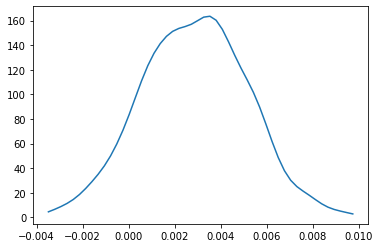

In [106]:
#df_3 = df.copy() #This was done at the begining of the question to save a copy of the data to use it here.

mean_age = np.mean(df_3.age)
x = 0
x_center = x - mean_age
prediction = []
for i in range(1000):
    prediction.append(posterior_samples_quad[i,0] + posterior_samples_quad[i,1] * x_center + posterior_samples_quad[i,2] * x_center**2)
# 95% confidence interval
pred_quantiles = np.quantile(prediction, q = [0.025, 0.975], axis = 0)
# sd
pred_sd = np.std(prediction, axis = 0)
# mean
pred_mean = np.mean(prediction, axis = 0)

summary_stats = [pred_mean, pred_sd, pred_quantiles[0],pred_quantiles[1]]

summary_stats = pd.DataFrame(summary_stats).transpose()
summary_stats.columns = ['mean', 'SD', '2.5%', '97.5%']
summary_stats.rename(index={0:'a',1:'b', 2:'c', 3:'sigma'}, inplace=True)
print(summary_stats)
#Plot
x_range = np.linspace(min(prediction), max(prediction))

data_density = gaussian_kde(prediction)
plt.plot(x_range, data_density(x_range))
plt.show()